In [1]:
import lfx
import flax.nnx as nnx
import flax
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt
import flax.typing as ftp
import typing as tp


# Normalizing flow basics

In [2]:
# we can start with a simple uniform [0, 1] distribution
# (although this may often not be a great choice since log_prob is -inf outside range)
prior = lfx.IndependentUniform(
    (),  # shape of samples; here a scalar
    rngs=nnx.Rngs(sample=0),  # random number generator for sampling
)

In [3]:
x, lp = prior.sample(batch_shape=(10,))
print(f'{x.shape=}, {lp.shape=}')

x.shape=(10,), lp.shape=(10,)


In [4]:
# very simple bijection
bijection = lfx.Chain([
    lfx.Scaling(2),
    lfx.Shift(-1),  # can specify floats/ints or shapes (-> parameters)
])

x, lp = bijection.forward(x, lp)

In [5]:
# combine into a 'sampler' (which is again a prior)
sampler = lfx.Sampler(prior, bijection)

# sample from the sampler
x, lp = sampler.sample(batch_shape=(7,))
print(f'{x.shape=}, {lp.shape=}')

x.shape=(7,), lp.shape=(7,)


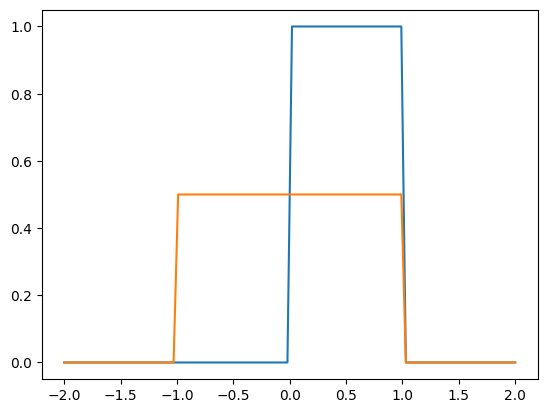

In [6]:
# all priors including samplers implement `log_prob`
x = np.linspace(-2, 2, 100)
plt.plot(x, jnp.exp(prior.log_prob(x)))
plt.plot(x, jnp.exp(sampler.log_prob(x)))
plt.show()

## Frozen and constant

In [7]:
# scaling (and shifts) parameters can be fixed or trainable parameters
fixed = lfx.Scaling(2.)
graph, const, params = nnx.split(fixed, lfx.filter_frozen, nnx.Param)
print(f'{const=}\n{params=}')

const=State({
  'scale_val': VariableState(
    type=Const,
    value=2.0
  )
})
params=State({})


In [8]:
trainable = lfx.Scaling((), rngs=nnx.Rngs(params=0))
graph, const, params = nnx.split(trainable, lfx.filter_frozen, nnx.Param)
print(f'{const=}\n{params=}')

const=State({})
params=State({
  'scale_val': VariableState(
    type=Param,
    value=Array(1., dtype=float32)
  )
})


In [9]:
# for convenience, e.g. when stacking flows or defining new priors,
# we can freeze bijections with the convenience class `Frozen`

frozen = lfx.Frozen(trainable)
graph, const, params = nnx.split(frozen, lfx.filter_frozen, nnx.Param)
print(f'{const=}\n{params=}')

const=State({
  'frozen': {
    'scale_val': VariableState(
      type=Param,
      value=Array(1., dtype=float32)
    )
  }
})
params=State({})


## Multi-event flows

It may not always be easy or desirable to have a single array as event.
While many particular layers work on arrays, it should be straightforward to
define new layers that work on more complex types.

Below is an example of how priors can be defined.
A similar approach can be taken for bijections.

In [10]:
class TwoNormal(lfx.Prior):

    def __init__(self, shape_1, shape_2, rngs: nnx.Rngs | None = None):
        super().__init__(rngs)
        self.prior_1 = lfx.IndependentNormal(shape_1, rngs=rngs)
        self.prior_2 = lfx.IndependentNormal(shape_2, rngs=rngs)

    def sample(self, batch_shape: tuple[int, ...] = (), *, rng: ftp.PRNGKey | None = None, **kwargs):
        rng1, rng2 = jax.random.split(self._get_rng(rng))
        x1, lp1 = self.prior_1.sample(batch_shape, rng=rng1, **kwargs)
        x2, lp2 = self.prior_2.sample(batch_shape, rng=rng2, **kwargs)
        return (x1, x2), lp1 + lp2

    def log_prob(self, x: tuple[jax.Array, jax.Array], **kwargs):
        x1, x2 = x
        lp1 = self.prior_1.log_prob(x1, **kwargs)
        lp2 = self.prior_2.log_prob(x2, **kwargs)
        return lp1 + lp2

    def get_batch_shape(self, x: tuple[jax.Array, jax.Array]):
        # could also assert both x's give the same batch shape
        return self.prior_1.get_batch_shape(x[0])


In [11]:
prior = TwoNormal((2,), (2,), rngs=nnx.Rngs(sample=0))

In [12]:
x, lp = prior.sample(batch_shape=(3,))
print(f'{x[0].shape=}, {x[1].shape=}, {lp.shape=}')

x[0].shape=(3, 2), x[1].shape=(3, 2), lp.shape=(3,)


# Continuous flow

Starting with a simple low-dimensional flow,
where we can compute the divergence via backprop.

In [13]:
from functools import partial
from jax_autovmap import auto_vmap

class VectorField(nnx.Module):

    def __init__(self, size: int, hidden=(128, 128, 128), *, activation=nnx.gelu, rngs):
        # let's assume here the event shape is simply (size,)
        self.size = size
        self.activation = activation
        self.layers = [
            nnx.Linear(inf, outf, rngs=rngs)
            for inf, outf in zip([size] + list(hidden), list(hidden) + [size])
        ]

    def vector_field_base(self, x):
        for layer in self.layers:
            x = layer(x)
            x = self.activation(x)
        return x

    def __call__(self, t, x):
        # now we need to augment the vector field to also return the negative divergence

        @auto_vmap(1)
        @partial(jax.vmap, in_axes=(None, 0), out_axes=(None, -1))
        def _jvp(x, tang):
            return jax.jvp(self.vector_field_base, (x,), (tang,))

        tang_basis = jnp.eye(x.shape[-1])  # assume event shape is just a vector
        v, jac = _jvp(x, tang_basis)
        return v, -jnp.trace(jac, axis1=-2, axis2=-1)

In [14]:
vf = VectorField(2, rngs=nnx.Rngs(params=0))

In [15]:
import diffrax


class ContFlow(lfx.Bijection):
    def __init__(self, vf, t_start=0, t_end=1, dt=1/20):
        self.vf = vf
        self.t_start = t_start
        self.t_end = t_end
        self.dt = dt

    def forward(self, x, log_density):
        term = diffrax.ODETerm(lambda t, state, args: self.vf(t, state[0]))
        solver = diffrax.Tsit5()
        y0 = (x, log_density)
        sol = diffrax.diffeqsolve(term, solver, t0=self.t_start, t1=self.t_end, dt0=self.dt, y0=y0)
        (x,), (log_density,) = sol.ys
        return x, log_density

    def reverse(self, x, log_density):
        term = diffrax.ODETerm(lambda t, state, args: self.vf(t, state[0]))
        solver = diffrax.Tsit5()
        y0 = (x, log_density)
        sol = diffrax.diffeqsolve(term, solver, t0=self.t_end, t1=self.t_start, dt0=-self.dt, y0=y0)
        (x,), (log_density,) = sol.ys
        return x, log_density


# let's start with a gaussian prior and define a sampler
prior = lfx.IndependentNormal((2,), rngs=nnx.Rngs(sample=0))
flow = ContFlow(vf)
sampler = lfx.Sampler(prior, flow)

In [16]:
# add noise to parameters
noise_rngs = nnx.Rngs(42)

graph, params, rest = nnx.split(sampler, nnx.Param, nnx.Variable)
params = jax.tree.map(lambda p: p + 0.1 * jax.random.normal(noise_rngs(), p.shape), params)
sampler = nnx.merge(graph, params, rest)

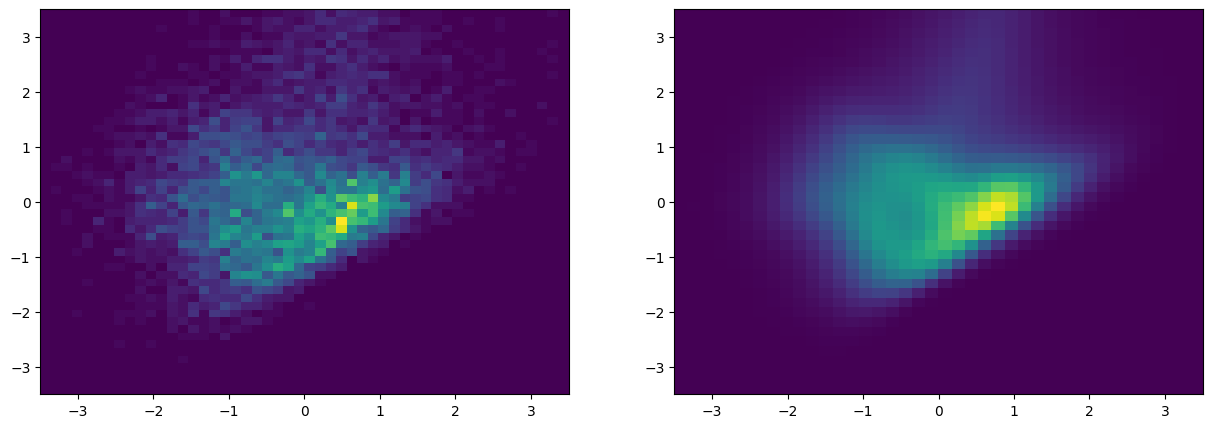

In [17]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
x, _ = sampler.sample((10000,))
plt.hist2d(*x.T, bins=50, range=[[-3.5, 3.5], [-3.5, 3.5]])
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

plt.subplot(1, 2, 2)
x, y = np.mgrid[-3.5:3.5:7/40, -3.5:3.5:7/40]
dens = np.exp(sampler.log_prob(np.stack([y, x], -1)))
plt.imshow(dens, extent=[-3.5, 3.5, -3.5, 3.5], origin='lower')
plt.gca().set_aspect('auto')

plt.show()